# Bank Customer Churn.

In today's competitive banking landscape, retaining customers is as crucial as acquiring new ones. Customer churn, the phenomenon where customers cease their relationship with a bank, can significantly impact a financial institution's bottom line. This machine learning project aims to develop a predictive model to identify customers at risk of churning, enabling proactive retention strategies.

## **1. Data Preparation.**

In [59]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mltable
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from azureml.train.automl import AutoMLConfig
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
# Load data
ml_client = MLClient.from_config(credential=DefaultAzureCredential())
data_asset = ml_client.data.get("bank_customer_data_new", version="1")

tbl = mltable.load(f'azureml:/{data_asset.id}')

df = tbl.to_pandas_dataframe()
df.head()

Found the config file in: /config.json


,RowNumber,CustomerId,Surname,First Name,Date of Birth,Gender,Marital Status,Number of Dependents,Occupation,Income,...,Preferred Communication Channel,Credit Score,Credit History Length,Outstanding Loans,Churn Flag,Churn Reason,Churn Date,Balance,NumOfProducts,NumComplaints
0,1,83ef0b54-35f6-4f84-af58-5653ac0c0dc4,Smith,Troy,1987-08-29,Male,Divorced,3,Information systems manager,77710.14,...,Phone,397,24,41959.74,0,None,NaT,211359.05,1,0
1,2,009f115a-e5ca-4cf4-97d6-530140545e4e,Sullivan,Katrina,2000-02-07,Female,Married,1,Charity fundraiser,58209.87,...,Email,665,10,8916.67,0,None,NaT,30624.76,4,1
2,3,66309fd3-5009-44d3-a3f7-1657c869d573,Fuller,Henry,1954-02-03,Female,Single,1,Television production assistant,9794.01,...,Email,715,21,43270.54,0,None,NaT,111956.61,2,6
3,4,b02a30df-1a5f-4087-8075-2a35432da641,Young,Antonio,1991-01-15,Female,Divorced,5,Agricultural engineer,15088.98,...,Phone,747,17,17887.65,0,None,NaT,201187.61,1,0
4,5,0d932e5b-bb3a-4104-8c83-f84270f7f2ea,Andersen,John,1992-04-08,Female,Divorced,2,"Teacher, early years/pre",60726.56,...,Email,549,25,32686.84,0,None,NaT,60391.24,5,6


In [3]:
# Length of the dataset.
df.shape

(115640, 25)

In [4]:
# Summary Statistics
df.describe()

,RowNumber,Date of Birth,Number of Dependents,Income,Customer Tenure,Credit Score,Credit History Length,Outstanding Loans,Churn Flag,Churn Date,Balance,NumOfProducts,NumComplaints
count,115640.000000,115640,115640.000000,115640.000000,115640.000000,115640.000000,115640.000000,115640.000000,115640.000000,14094,115640.000000,115640.000000,115640.000000
mean,57820.500000,1977-08-14 20:20:58.443445184,2.502923,52641.363046,15.490591,574.299775,15.546602,25502.731792,0.121878,2024-04-20 05:09:59.233716480,124639.209748,2.999274,4.991724
min,1.000000,1948-08-09 00:00:00,0.000000,5000.960000,1.000000,300.000000,1.000000,1000.430000,0.000000,2024-01-01 00:00:00,1.060000,1.000000,0.000000
25%,28910.750000,1963-02-22 00:00:00,1.000000,28857.070000,8.000000,436.000000,8.000000,13226.060000,0.000000,2024-02-26 00:00:00,61991.915000,2.000000,2.000000
50%,57820.500000,1977-09-15 00:00:00,3.000000,52658.110000,15.000000,574.000000,16.000000,25505.285000,0.000000,2024-04-21 00:00:00,124505.890000,3.000000,5.000000
75%,86730.250000,1992-01-05 00:00:00,4.000000,76364.157500,23.000000,712.000000,23.000000,37742.250000,0.000000,2024-06-14 00:00:00,187122.922500,4.000000,8.000000
max,115640.000000,2006-08-07 00:00:00,5.000000,99999.510000,30.000000,850.000000,30.000000,49999.690000,1.000000,2024-08-07 00:00:00,249998.910000,5.000000,10.000000
std,33382.536902,NaN,1.707249,27429.756390,8.654217,159.067499,8.654630,14127.859827,0.327147,NaN,72210.476638,1.411361,3.159283


In [5]:
# Features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115640 entries, 0 to 115639
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   RowNumber                        115640 non-null  int64         
 1   CustomerId                       115640 non-null  object        
 2   Surname                          115640 non-null  object        
 3   First Name                       115640 non-null  object        
 4   Date of Birth                    115640 non-null  datetime64[ns]
 5   Gender                           115640 non-null  object        
 6   Marital Status                   115640 non-null  object        
 7   Number of Dependents             115640 non-null  int64         
 8   Occupation                       115640 non-null  object        
 9   Income                           115640 non-null  float64       
 10  Education Level                  115640 non-

## Errors and inconsistencies in the data.

1. Missing values 

- `Solution` - Identify the percentage and either fill with (mean, mode) or drop them.

2. Find all outliers in the dataset.

- `Solution` - Remove them, imputation.

## **2. Data Cleaning.**

In [6]:
# Missing values
df.isnull().sum()

RowNumber                               0
CustomerId                              0
Surname                                 0
First Name                              0
Date of Birth                           0
Gender                                  0
Marital Status                          0
Number of Dependents                    0
Occupation                              0
Income                                  0
Education Level                         0
Address                                 0
Contact Information                     0
Customer Tenure                         0
Customer Segment                        0
Preferred Communication Channel         0
Credit Score                            0
Credit History Length                   0
Outstanding Loans                       0
Churn Flag                              0
Churn Reason                       101546
Churn Date                         101546
Balance                                 0
NumOfProducts                     

`Churn Reason` & `Churn Date` has > 90% missing values.
- Solution - Drop the features / columns

In [7]:
# Drop [Churn Reason, Churn Date]
data = df.drop(["Churn Reason", "Churn Date"], axis=1)



In [8]:
# Missing values
data.isnull().sum()

RowNumber                          0
CustomerId                         0
Surname                            0
First Name                         0
Date of Birth                      0
Gender                             0
Marital Status                     0
Number of Dependents               0
Occupation                         0
Income                             0
Education Level                    0
Address                            0
Contact Information                0
Customer Tenure                    0
Customer Segment                   0
Preferred Communication Channel    0
Credit Score                       0
Credit History Length              0
Outstanding Loans                  0
Churn Flag                         0
Balance                            0
NumOfProducts                      0
NumComplaints                      0
dtype: int64

## **3. Exploratory Data Analysis.**

#### **a) Distribution of Target Variable.**

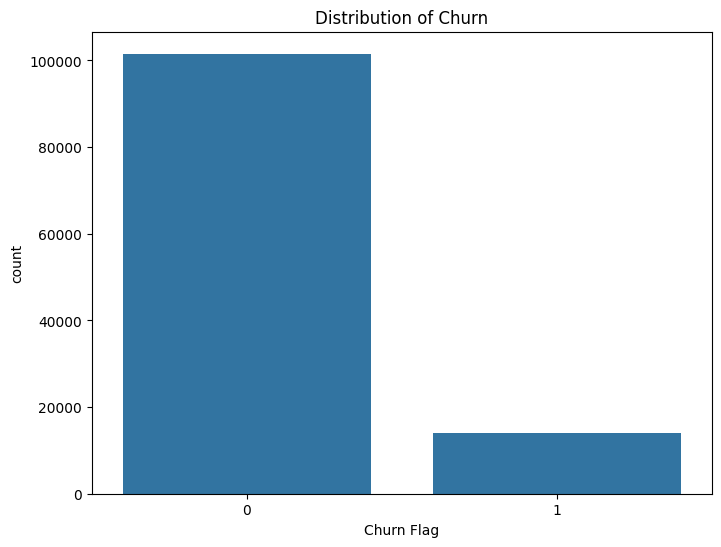

In [9]:
# Churn vs Not Churn distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn Flag', data=data)
plt.title('Distribution of Churn')
plt.show()

Insight - There is a huge imbalance between the two classes.

`Solution` 
        
    1. Class Weights in the Model 1

    2. Undersample the Majority Class in Model 2

#### **b) Correlation among features.**

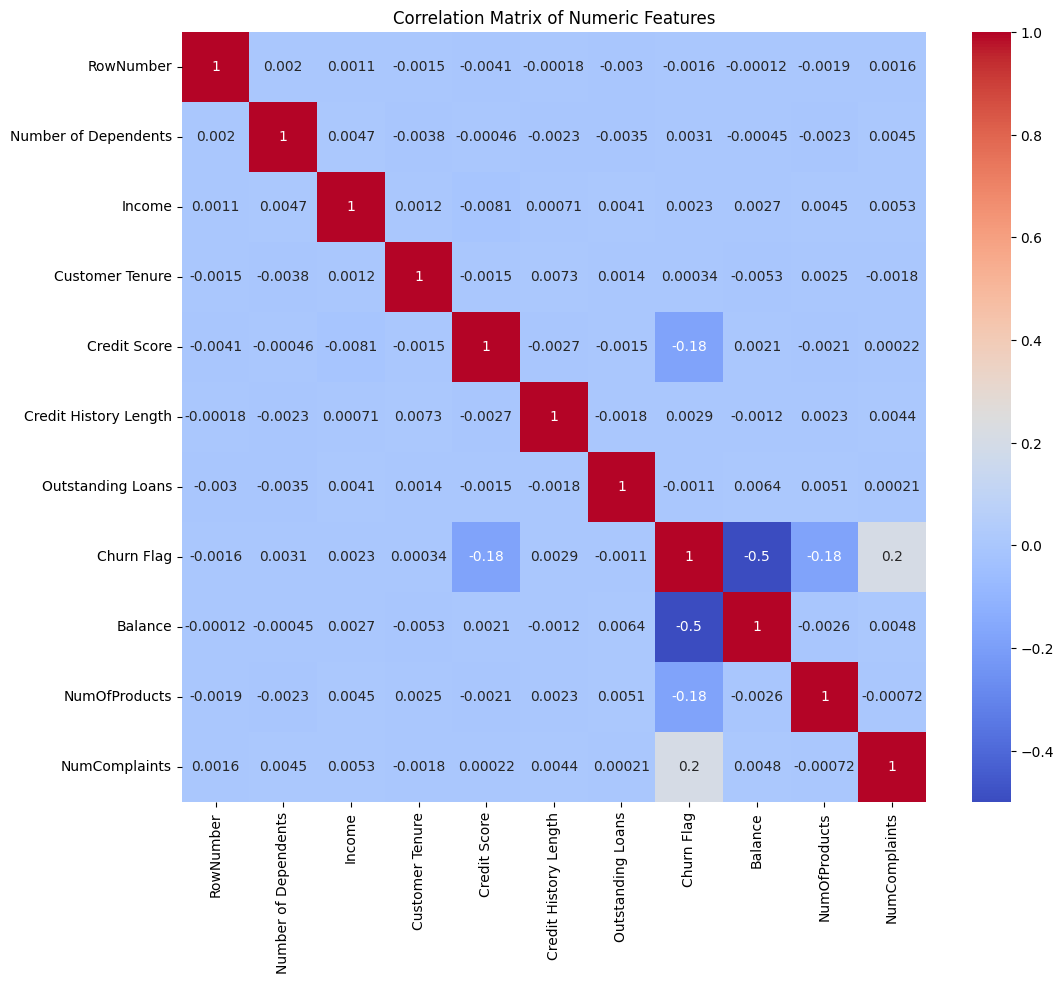

In [10]:
# correlation matrix
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

#### **c) Average balance by churn status.**

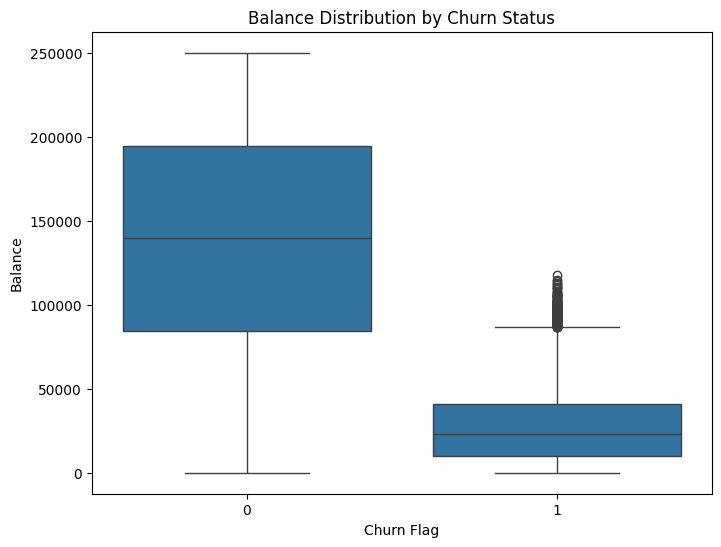

In [11]:
# Average balance by churn status
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn Flag', y='Balance', data=df)
plt.title('Balance Distribution by Churn Status')
plt.show()

#### **d) Income Distribution.**

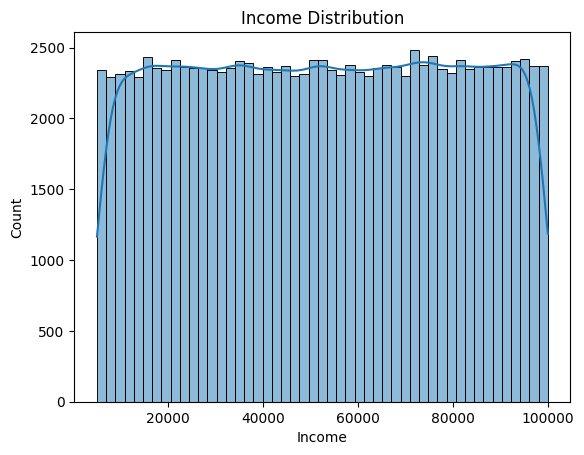

In [12]:
# Distribution of income
sns.histplot(df['Income'], kde=True)
plt.title('Income Distribution')
plt.show()

#### **e) Key Insights.**

In [13]:
print(f"Churn Rate: {df['Churn Flag'].mean():.2%}")
print(f"Average Customer Tenure: {df['Customer Tenure'].mean():.2f} years")
print(f"Most Common Customer Segment: {df['Customer Segment'].mode()[0]}")

Churn Rate: 12.19%
Average Customer Tenure: 15.49 years
Most Common Customer Segment: SME


## **4. Feature Engineering & Model Building**

In [25]:
# Calculate age in years
data['Age'] = (pd.Timestamp.now() - data['Date of Birth']).dt.days // 365

# Create HasComplaints column
data['HasComplaints'] = data['NumComplaints'] > 0


In [26]:
# Split the data
X = data.drop(['Churn Flag', 'RowNumber', 'CustomerId', 'Surname', 'First Name', 'Date of Birth', 'Address', 'Contact Information'], axis=1)
y = data['Churn Flag']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [28]:
# Define preprocessing steps
numeric_features = ['Age', 'Number of Dependents', 'Income', 'Customer Tenure', 'Credit Score', 'Credit History Length', 'Outstanding Loans', 'Balance', 'NumOfProducts', 'NumComplaints']
categorical_features = ['Gender', 'Marital Status', 'Occupation', 'Education Level', 'Customer Segment', 'Preferred Communication Channel', 'HasComplaints']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [29]:
# Create a pipeline that includes preprocessing and resampling
imbalance_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  # Oversampling
    ('undersampler', RandomUnderSampler(random_state=42))  # Undersampling
])

In [30]:
# Fit the pipeline and transform the data
X_resampled, y_resampled = imbalance_pipeline.fit_resample(X_train, y_train)

print("Shape of training data after resampling:", X_resampled.shape)
print("Distribution of classes after resampling:")
print(pd.Series(y_resampled).value_counts(normalize=True))

Shape of training data after resampling: (162474, 665)
Distribution of classes after resampling:
Churn Flag
0    0.5
1    0.5
Name: proportion, dtype: float64


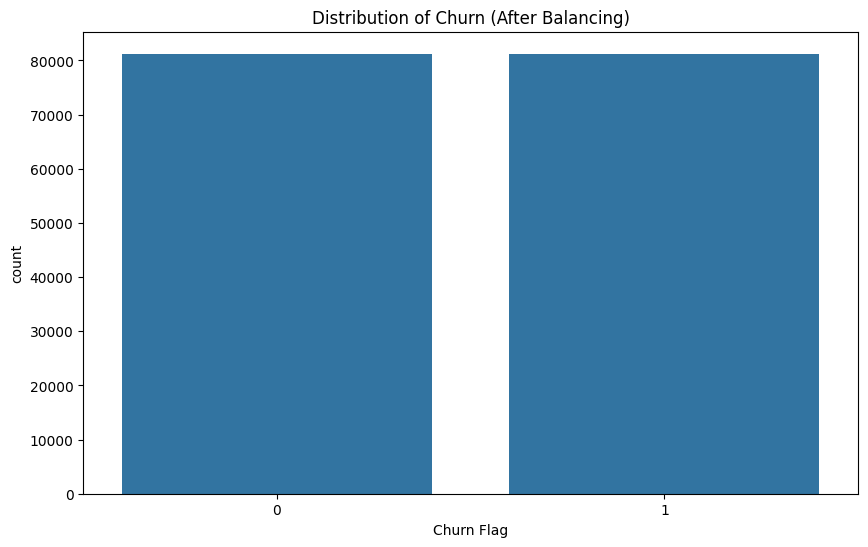

In [31]:
# Visualize the balanced dataset
plt.figure(figsize=(10, 6))
sns.countplot(x=y_resampled)
plt.title('Distribution of Churn (After Balancing)')
plt.show()


In [32]:
# Combine X_resampled and y_resampled into a single dataframe
resampled_data = pd.concat([pd.DataFrame(X_resampled), pd.Series(y_resampled, name='Churn Flag')], axis=1)

In [62]:
from azureml.core import Workspace, Experiment, Model, Environment
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.online_endpoint import OnlineEndpoint, AzureMLOnlineEndpointPolicy
from azureml.core.online_deployment import OnlineDeployment

ModuleNotFoundError: No module named 'azureml.core.online_endpoint'

In [63]:
!pip install azureml.core.online_endpoint

ERROR: Could not find a version that satisfies the requirement azureml.core.online_endpoint (from versions: none)
ERROR: No matching distribution found for azureml.core.online_endpoint


In [42]:
# Get the default datastore from the workspace
# Ensure you're connected to your workspace
ws = Workspace.from_config()
datastore = ws.get_default_datastore()

In [49]:
import numpy as np
from scipy.sparse import csr_matrix

# Identify columns that might contain sparse matrices
for column in resampled_data.columns:
    if isinstance(resampled_data[column].iloc[0], csr_matrix):
        resampled_data[column] = resampled_data[column].apply(lambda x: x.toarray() if isinstance(x, csr_matrix) else x)


In [50]:
# Convert object columns to string where appropriate
for column in resampled_data.select_dtypes(include=['object']).columns:
    resampled_data[column] = resampled_data[column].astype(str)


In [51]:
# Register the dataset
dataset = Dataset.Tabular.register_pandas_dataframe(
    dataframe=resampled_data, 
    target=datastore, 
    name='churn_prediction_balanced'
)

Validating arguments.
Arguments validated.
Validating arguments.
Arguments validated.
'overwrite' is set to True. Any file already present in the target will be overwritten.
Uploading files from '/tmp/tmpi3gtk4wj' to 'managed-dataset/3e1bd4eb-de83-4778-a70f-7a9108018177/'
Copying 1 files with concurrency set to 1
Copied /tmp/tmpi3gtk4wj/dataframe.parquet, file 1 out of 1. Destination path: https://bankcustomerch6455549120.blob.core.windows.net/azureml-blobstore-e92861d4-c8ff-4d82-be54-5a5f3d70c78f/managed-dataset/3e1bd4eb-de83-4778-a70f-7a9108018177/dataframe.parquet
Files copied=1, skipped=0, failed=0
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pandas/io/parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


#### **Deploy the model**